In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
group_data=pd.read_csv('data.csv')
df=pd.read_csv('data.csv')

In [3]:
E = group_data.sdEnergy.unique()
lgE = np.log10(E)
lgEmin = 18.4
lgEmax = 20.1
dlgE = 0.1

lgECenters = np.arange(lgEmin + dlgE/2., lgEmax, dlgE)
ECenters = 10.**lgECenters
Counts = np.zeros(len(lgECenters))
c=np.zeros(len(lgE))
for i in range(0, len(lgE)):
    thisLgE = lgE[i]
    ibin = int((thisLgE - lgEmin)/dlgE)

    if(thisLgE < lgEmin or thisLgE > lgEmax):
        print ("Event energy out of range: lgE =", thisLgE)
        sys.exit()

    Counts[ibin] +=1
    c[i]=ibin

In [4]:
train_count=[]
test_count=[]
val_count=[]
train=pd.DataFrame()
test=pd.DataFrame()
val=pd.DataFrame()
#group_data=df.copy()
for i in range(len(Counts)):
    id1=[]
    for j in range(len(c)):
        if i==c[j]:
            id1.append(df.eventId.unique()[j])
    if len(id1)>2:
        train_id,temp=train_test_split(id1, test_size=0.4, random_state=42)
        val_id,test_id=train_test_split(temp, test_size=0.5, random_state=42)

        train_temp = group_data.loc[group_data['eventId'].isin(train_id)]
        test_temp = group_data.loc[group_data['eventId'].isin(test_id)]
        val_temp = group_data.loc[group_data['eventId'].isin(val_id)]

        train=train.append(train_temp,ignore_index=True)
        test=test.append(test_temp,ignore_index=True)
        val=val.append(val_temp,ignore_index=True)
        
        train_count.append(train_temp.shape[0])
        test_count.append(test_temp.shape[0])
        val_count.append(val_temp.shape[0])
    elif len(id1)==2:
        train_id,test_id=train_test_split(id1, test_size=0.5, random_state=42)
        #val_id,test_id=train_test_split(temp, test_size=0.5, random_state=42)

        train_temp = group_data.loc[group_data['eventId'].isin(train_id)]
        test_temp = group_data.loc[group_data['eventId'].isin(test_id)]
        #val_temp = group_data.loc[group_data['eventId'].isin(val_id)]

        train=train.append(train_temp,ignore_index=True)
        test=test.append(test_temp,ignore_index=True)
        #val=val.append(val_temp,ignore_index=True)
        
        train_count.append(train_temp.shape[0])
        test_count.append(test_temp.shape[0])
        val_count.append(0)
    
    elif len(id1)==1:
        
        test_temp = group_data.loc[group_data['eventId'].isin(id1)]
        

        test=test.append(test_temp,ignore_index=True)
        
        train_count.append(0)
        test_count.append(test_temp.shape[0])
        val_count.append(0)
    
    else:
        train_count.append(0)
        test_count.append(0)
        val_count.append(0)
    
print('training data count',sum(train_count))
print('testing data count',sum(test_count))
print('validation data count',sum(val_count))
print('train data',train.shape)
print('test data',test.shape)
print('val data',val.shape)
print(sum(train_count)+sum(test_count)+sum(val_count))   

assert (sum(train_count)+sum(test_count)+sum(val_count))==group_data.shape[0]
train_count = pd.DataFrame(train_count)
train_count.to_csv('train_count.csv')

test_count = pd.DataFrame(test_count)
test_count.to_csv('test_count.csv')

val_count = pd.DataFrame(val_count)
val_count.to_csv('val_count.csv')

df_train=train.drop(columns=[ 'eventId', 'sId', 'sPMT','sTimeSec', 'sTimeNsec',
       'sSignalStart', 'sSignalEnd','fdXmaxErr','sVEM','sStatus','sXrel','sYrel','sZrel'])
df_test=test.drop(columns=['eventId', 'sId', 'sPMT','sTimeSec', 'sTimeNsec',
       'sSignalStart', 'sSignalEnd','fdXmaxErr','sVEM','sStatus','sXrel','sYrel','sZrel'])
df_val=val.drop(columns=['eventId', 'sId', 'sPMT','sTimeSec', 'sTimeNsec',
       'sSignalStart', 'sSignalEnd','fdXmaxErr','sVEM','sStatus','sXrel','sYrel','sZrel'])
df.shape

train.to_csv('train.csv')
test.to_csv('test.csv')
val.to_csv('val.csv')

training data count 17
testing data count 13
validation data count 7
train data (17, 2263)
test data (13, 2263)
val data (7, 2263)
37


In [5]:
print(198+188+71)

457


In [6]:
len(train_count)

17

In [7]:
y_train=np.array(df_train['fdXmax'].to_list())
y_train=np.reshape(y_train, (-1,1))
X_train=df_train.drop(columns=['fdXmax'])

y_test=np.array(df_test['fdXmax'].to_list())
y_test=np.reshape(y_test, (-1,1))
X_test=df_test.drop(columns=['fdXmax'])

y_val=np.array(df_val['fdXmax'].to_list())
y_val=np.reshape(y_val, (-1,1))
X_val=df_val.drop(columns=['fdXmax'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.head()

,sdEnergy,sdEnergyErr,sdZenith,sdZenithErr,sdAzimuth,sdAzimuthErr,sdXpos,sdYpos,sdZpos,sdS1000,...,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231
0,3.600975e+18,2.593796e+17,0.474284,0.007129,4.280367,0.023043,6856.651531,-14488.238926,-41.721123,20.095232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.485317e+18,5.932678e+17,0.999678,0.006686,4.220127,0.008542,-4072.948623,-6538.437565,-8.128227,10.211523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.445948e+18,5.166201e+17,0.582423,0.012082,5.977738,0.021586,25922.458807,5633.288666,-98.511341,18.405171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.299685e+18,2.457104e+17,0.464980,0.014179,1.006157,0.019793,10992.424099,22571.574994,-77.300190,18.780606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.795948e+18,3.040166e+17,0.637685,0.008842,5.019198,0.008233,-11474.741918,-21851.360587,-58.796975,19.926580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_train1=X_train.iloc[: ,0:17].copy()
X_train2=X_train.iloc[: ,17:].copy()
X_test1=X_test.iloc[: ,0:17].copy()
X_test2=X_test.iloc[: ,17:].copy()
X_val1=X_val.iloc[: ,0:17].copy()
X_val2=X_val.iloc[: ,17:].copy()

In [10]:
X_train.columns

Index(['sdEnergy', 'sdEnergyErr', 'sdZenith', 'sdZenithErr', 'sdAzimuth',
       'sdAzimuthErr', 'sdXpos', 'sdYpos', 'sdZpos', 'sdS1000',
       ...
       '2222', '2223', '2224', '2225', '2226', '2227', '2228', '2229', '2230',
       '2231'],
      dtype='object', length=2249)

In [11]:
#y_train=np.array(df_train['fdXmax'].to_list())
#y_train=np.reshape(y_train, (-1,1))

In [12]:

#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)


In [13]:
y_train.shape[0]

17

In [14]:
scaler_x1 = MinMaxScaler()
scaler_x2 = MinMaxScaler()
scaler_y = MinMaxScaler()

fit_X1=scaler_x1.fit(X_train1)
X_train1=fit_X1.transform(X_train1)
X_test1=fit_X1.transform(X_test1)
X_val1=fit_X1.transform(X_val1)

fit_X2=scaler_x2.fit(X_train2)
X_train2=fit_X2.transform(X_train2)
X_test2=fit_X2.transform(X_test2)
X_val2=fit_X2.transform(X_val2)

fit_y=scaler_y.fit(y_train)
y_train=fit_y.transform(y_train)
y_test=fit_y.transform(y_test)
y_val=fit_y.transform(y_val)

In [15]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.merge import add
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

In [16]:
X_train1.shape

(17, 17)

In [17]:
X_train2 = np.expand_dims(X_train2,2)
X_val2 = np.expand_dims(X_val2,2)
X_test2 = np.expand_dims(X_test2,2)

In [58]:
import numpy as np
#from keras.layers import LSTM
np.random.seed(1337)

inputs1 = Input(shape=(X_train1.shape[1],))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(inputs1)

#model = Sequential()
#model.add(Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dense(300, kernel_initializer='normal', activation='relu'))
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))
#model.add(Dense(30, kernel_initializer='normal', activation='relu'))

model = Sequential()
inputs2 = Input(shape=(X_train2.shape[1],X_train2.shape[2]))
se1=Conv1D(filters=64, kernel_size=3, activation='relu')(inputs2)
se2=Conv1D(filters=64, kernel_size=3, activation='relu')(se1)
se3 = Dropout(0.5)(se2)
se4 = MaxPooling1D(pool_size=2)(se2)
se5 = Flatten()(se4)
se6 = Dense(256, activation='relu')(se5)


decoder1 = add([fe2, se6])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(1, activation='sigmoid')(decoder2)
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


#model = Sequential()
#model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
#model.add(Dense(1))


model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 2232, 1)      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 2230, 64)     256         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 2228, 64)     12352       conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 1114, 64)     0           conv1d_8[0][0]                   
____________________________________________________________________________________________

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse','mae'])

In [70]:
history=model.fit([X_train1, X_train2], y_train, epochs=50, verbose=2,  validation_data=([X_val1, X_val2], y_val),shuffle=False)

Train on 17 samples, validate on 7 samples
Epoch 1/50
 - 1s - loss: 0.6817 - mse: 0.0486 - mae: 0.1597 - val_loss: 0.7107 - val_mse: 0.0387 - val_mae: 0.1689
Epoch 2/50
 - 1s - loss: 0.6528 - mse: 0.0361 - mae: 0.1163 - val_loss: 0.6617 - val_mse: 0.0253 - val_mae: 0.1439
Epoch 3/50
 - 1s - loss: 0.6446 - mse: 0.0319 - mae: 0.1232 - val_loss: 0.7924 - val_mse: 0.0678 - val_mae: 0.1946
Epoch 4/50
 - 1s - loss: 0.6506 - mse: 0.0346 - mae: 0.1447 - val_loss: 0.9159 - val_mse: 0.0834 - val_mae: 0.2022
Epoch 5/50
 - 1s - loss: 0.6582 - mse: 0.0384 - mae: 0.1591 - val_loss: 0.9503 - val_mse: 0.0871 - val_mae: 0.2067
Epoch 6/50
 - 1s - loss: 0.6608 - mse: 0.0396 - mae: 0.1631 - val_loss: 0.9451 - val_mse: 0.0873 - val_mae: 0.2084
Epoch 7/50
 - 1s - loss: 0.6595 - mse: 0.0390 - mae: 0.1613 - val_loss: 0.9100 - val_mse: 0.0845 - val_mae: 0.2075
Epoch 8/50
 - 1s - loss: 0.6555 - mse: 0.0370 - mae: 0.1553 - val_loss: 0.8526 - val_mse: 0.0786 - val_mae: 0.2070
Epoch 9/50
 - 1s - loss: 0.6504 - mse

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


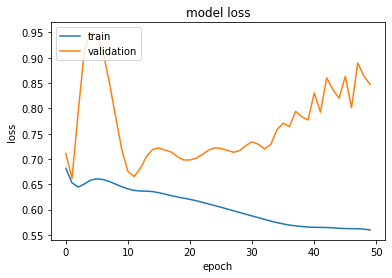

In [71]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("model_loss.png")
plt.show()

In [72]:
y_pred= model.predict([X_test1, X_test2])

In [73]:
y_pred.shape

(13, 1)

In [74]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print('normal mse',sqrt(mean_squared_error(y_test, y_pred)))
print('normal mae',mean_absolute_error(y_test, y_pred))

normal mse 0.3962104395740978
normal mae 0.31909388386460846


In [75]:
y_test.shape
y_test=np.reshape(y_test, (y_test.shape[0],1))
y_pred=np.reshape(y_pred, (y_test.shape[0],1))
y_test_normalized=scaler_y.inverse_transform(y_test)
y_pred_normalized=scaler_y.inverse_transform(y_pred)
y_test=np.reshape(y_test, (y_test.shape[0],))
y_pred=np.reshape(y_pred, (y_test.shape[0],))
y_test_normalized=np.reshape(y_test_normalized, (y_test.shape[0],))
y_pred_normalized=np.reshape(y_pred_normalized, (y_test.shape[0],))

In [76]:
print('mse',sqrt(mean_squared_error(y_test_normalized, y_pred_normalized)))

mse 190.78641752298773


In [77]:
print('mae',mean_absolute_error(y_test_normalized, y_pred_normalized))

mae 153.65262706212678


In [46]:
df_result=pd.DataFrame()

df_result['Normalized True Value']=y_test
df_result['Normalized Predicted Value']=y_pred
df_result['True Value']=y_test_normalized
df_result['Predicted Value']=y_pred_normalized

df_result.to_csv('results.csv')

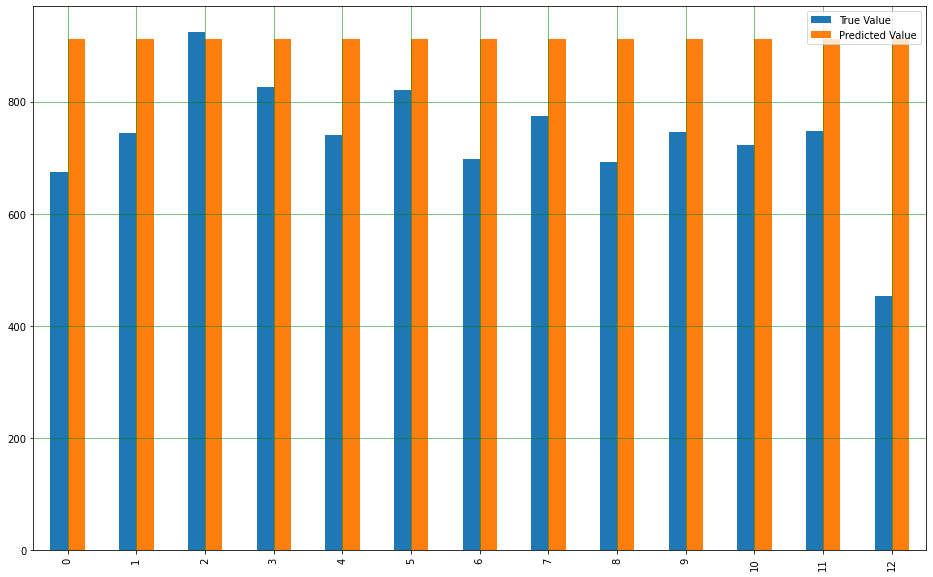

In [47]:
df1 = df_result[['True Value','Predicted Value']]
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [38]:
test.to_csv('test.csv')

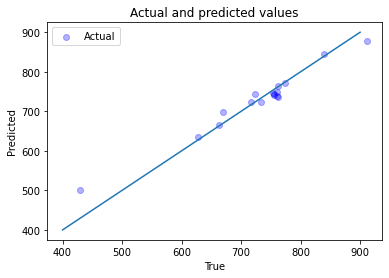

In [54]:
_, ax = plt.subplots()
x = [ 400, 500, 600, 700,800,900]
y = [400, 500, 600, 700,800,900]
ax.scatter(x = df_result['True Value'], y=df_result['Predicted Value'], c = 'blue', label = 'Actual', alpha = 0.3)
#ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)
plt.plot(x,y)
plt.title('Actual and predicted values')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.savefig("actual_vs_predicted.png")
plt.show()


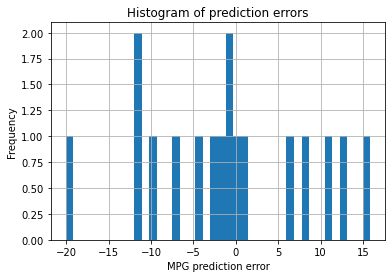

In [40]:
diff = df_result['True Value'] - df_result['Predicted Value']
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')
plt.savefig('prediction_histogram.png')

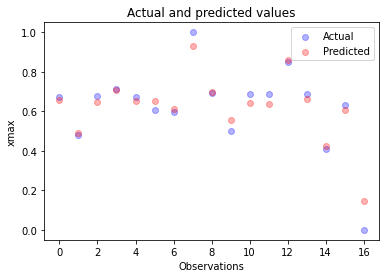

In [55]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('xmax')
plt.legend()
plt.savefig("xmax_vs_observation.png")
plt.show()


In [ ]:
# partial caption sequence model
inputs2 = Input(shape=(X_train2.shape[1],))
se1 = Embedding(X_train2.shape[0], 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)